In [1]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string

In [2]:
newsgroups_dataset = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'), random_state=42)


# Ensure stopwords are downloaded
nltk.download('stopwords')
nltk.download('punkt')

# Initialize stopwords, stemmer, and punctuation set
stop_words = set(stopwords.words('english'))
punctuation_set = set(string.punctuation)
stemmer = PorterStemmer()

def preprocess_text(text):
    # Tokenize text
    tokens = word_tokenize(text)
    # Convert to lowercase, remove punctuation, remove stopwords, and stem
    processed_tokens = [stemmer.stem(word.lower()) for word in tokens if word.lower() not in stop_words and word not in punctuation_set]
    # Re-join processed tokens into a single string
    return ' '.join(processed_tokens)

# Apply preprocessing to each document in the dataset
processed_data = [preprocess_text(doc) for doc in newsgroups_dataset.data]
# Use TfidfVectorizer to convert the raw text into TF-IDF features
print("Vectorizing the text data...")
tfidf_vectorizer = CountVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(processed_data)
n_components = 100
svd = TruncatedSVD(n_components=n_components, random_state=42)
tfidf_matrix_reduced = svd.fit_transform(tfidf_matrix)
if tfidf_matrix_reduced.dtype == 'float64':
    tfidf_matrix_reduced = tfidf_matrix_reduced.astype('float32')

[nltk_data] Downloading package stopwords to C:\Users\Devendra
[nltk_data]     Nemade\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Devendra
[nltk_data]     Nemade\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Vectorizing the text data...


In [3]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances

# Objective function: Inertia (Sum of squared distances to nearest cluster center)
def compute_inertia(centroids, data, threshold=100000, distance_metric='manhattan'):
    # Choose distance metric
    if distance_metric == 'euclidean':
        distances = euclidean_distances(data, centroids)
    elif distance_metric == 'manhattan':
        distances = manhattan_distances(data, centroids)
    else:
        raise ValueError("Unsupported distance metric. Choose 'euclidean' or 'manhattan'.")

    labels = np.argmin(distances, axis=1)
    min_distances = np.min(distances, axis=1)

    # Assign -1 for distances greater than threshold
    labels[min_distances > threshold] = -1

    # Compute inertia for assigned data points
    assigned_data_points = data[labels != -1]
    if len(assigned_data_points) > 0:
        assigned_labels = labels[labels != -1]
        inertia = np.sum((assigned_data_points - centroids[assigned_labels]) ** 2)
    else:
        inertia = 0

    # Calculate additional metrics if needed
    num_outliers = np.sum(labels == -1)
    average_distance = np.mean(min_distances[labels != -1]) if len(assigned_data_points) > 0 else 0

    return inertia, labels


import numpy as np
from scipy.special import gamma  # Import gamma from scipy.special

def levy_flight(mu, size):
    sigma = (gamma(1 + mu) * np.sin(np.pi * mu / 2) / 
             (gamma((1 + mu) / 2) * mu * 2 ** ((mu - 1) / 2))) ** (1 / mu)
    u = np.random.normal(0, sigma, size)
    v = np.random.normal(0, 1, size)
    step = u / np.abs(v) ** (1 / mu)
    return step

# Cuckoo Search Update
def cuckoo_search(nests, best_nest, data, lb, ub, levy_size=0.01):
    new_nests = np.copy(nests)
    for i in range(len(nests)):
        step_size = levy_flight(1.5, nests[i].shape) * levy_size
        new_nests[i] += step_size * (nests[i] - best_nest)
        new_nests[i] = np.clip(new_nests[i], lb, ub)  # Ensure within bounds
        if compute_inertia(new_nests[i].reshape(-1, data.shape[1]), data) < compute_inertia(nests[i].reshape(-1, data.shape[1]), data):
            nests[i] = new_nests[i]
    return nests

# Particle Swarm Optimization Update
def pso_update(particles, velocities, pbest_positions, gbest_position, w=0.5, c1=0.8, c2=0.9):
    for i in range(len(particles)):
        r1, r2 = np.random.rand(), np.random.rand()
        velocities[i] = w * velocities[i] + c1 * r1 * (pbest_positions[i] - particles[i]) + c2 * r2 * (gbest_position - particles[i])
        particles[i] += velocities[i]
    return particles, velocities

# Hybrid Cuckoo-PSO-KMeans
def cuckoo_pso_kmeans(data, n_clusters, n_particles=10, max_iter=100):
    lb, ub = np.min(data, axis=0), np.max(data, axis=0)
    dims = data.shape[1]

    # Initialize nests (centroids) randomly for Cuckoo Search
    nests = np.random.uniform(lb, ub, (n_particles, n_clusters, dims))
    
    # Initialize particles and velocities for PSO
    particles = np.random.uniform(lb, ub, (n_particles, n_clusters, dims))
    velocities = np.zeros_like(particles)
    
    # Best positions and scores for PSO
    pbest_positions = np.copy(particles)
    pbest_scores = np.array([compute_inertia(p.reshape(-1, dims), data)[0] for p in pbest_positions])    
    gbest_position = pbest_positions[np.argmin(pbest_scores)]
    gbest_score = np.min(pbest_scores)
    
    for iteration in range(max_iter):
        # Cuckoo Search on nests
        nests = cuckoo_search(nests, gbest_position.reshape(-1, dims), data, lb, ub)
        
        # Update PSO particles
        particles, velocities = pso_update(particles, velocities, pbest_positions, gbest_position, w=0.5, c1=0.8, c2=0.9)
        
        # Evaluate and Update Best Scores and Positions
        for i in range(n_particles):
            current_score ,_= compute_inertia(particles[i].reshape(-1, dims), data)
            if current_score < pbest_scores[i]:
                pbest_scores[i] = current_score
                pbest_positions[i] = particles[i]
                if current_score < gbest_score:
                    gbest_score = current_score
                    gbest_position = particles[i]
                    
        # Optional: Here, you can integrate a KMeans refinement step
        
    # Final KMeans to refine centroids
    final_kmeans = KMeans(n_clusters=n_clusters, init=gbest_position.reshape(-1, dims), n_init=1)
    final_kmeans.fit(data)
    
    return final_kmeans.cluster_centers_, final_kmeans.labels_, final_kmeans.inertia_


n_clusters = 2
best_centroids, labels, best_score = cuckoo_pso_kmeans(tfidf_matrix_reduced, n_clusters)
print("Best Centroids:", best_centroids)
silhouette = silhouette_score(tfidf_matrix_reduced, labels)
davies_bouldin = davies_bouldin_score(tfidf_matrix_reduced, labels)
calinski_harabasz = calinski_harabasz_score(tfidf_matrix_reduced, labels)

print(f"Silhouette Score: {silhouette}")
print(f"Davies-Bouldin Index: {davies_bouldin}")
print(f"Calinski-Harabasz Index: {calinski_harabasz}")

Best Centroids: [[ 5.04345655e-01  1.75398970e+00  6.15715533e-02 -1.08468807e+00
  -6.46427572e-02 -1.71508551e-01 -8.88242200e-02 -5.98451234e-02
   1.17831096e-01 -6.94411770e-02  7.37332646e-03  5.09967618e-02
   2.19510183e-01  6.04835749e-02 -1.34319991e-01 -1.91205647e-02
  -2.38375440e-02  4.01080400e-02 -1.25613704e-01 -4.55175005e-02
   2.97932830e-02  1.75041437e-01  9.19370130e-02  5.39145730e-02
   1.80910714e-02  1.26077861e-01  9.40385535e-02 -2.53615171e-01
  -3.52175608e-02 -4.90022004e-02  4.79284637e-02 -6.70244768e-02
  -2.52408814e-02 -1.14938527e-01 -7.61452783e-03 -3.08511630e-02
  -4.63499874e-03 -4.86795865e-02  5.34312949e-02 -6.47497326e-02
  -2.92198453e-02  2.16123909e-02 -5.38210869e-02  5.89767136e-02
   1.35851642e-02  6.32522255e-02  4.51857038e-02  1.35290608e-01
  -1.27435625e-02 -6.54510548e-03 -1.16699763e-01 -8.32765698e-02
   9.19513255e-02  1.58796534e-02  6.85447305e-02 -5.15954420e-02
  -8.22786689e-02  9.20831114e-02  5.36299013e-02 -8.8960444

In [4]:
from sklearn.decomposition import PCA
silhouette_scores = []
davies_bouldin_scores = []
calinski_harabasz_scores = []
for n_clusters in range(2, 21):
    # Run PSO-KMeans with the current number of clusters
    best_centroids, labels, best_score = cuckoo_pso_kmeans(tfidf_matrix_reduced, n_clusters)


    # Calculate metrics
    silhouette = silhouette_score(tfidf_matrix_reduced, labels)
    davies_bouldin = davies_bouldin_score(tfidf_matrix_reduced,labels)
    calinski_harabasz = calinski_harabasz_score(tfidf_matrix_reduced,labels)

    # Store metrics
    silhouette_scores.append(silhouette)
    print(silhouette)
    davies_bouldin_scores.append(davies_bouldin)
    calinski_harabasz_scores.append(calinski_harabasz)

0.99854606
0.9977619
0.9973085
0.99683267
0.9969964
0.9970229
0.9965971
0.9966398
0.97774553
0.9845501
0.9761947
0.97657806
0.97622555
0.9747636
0.9750666
0.9568732
0.95657533
0.93094945
0.93011034


C:\Users\Devendra Nemade\AppData\Local\Temp\ipykernel_22328\587791035.py:23: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
C:\Users\Devendra Nemade\AppData\Local\Temp\ipykernel_22328\587791035.py:25: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


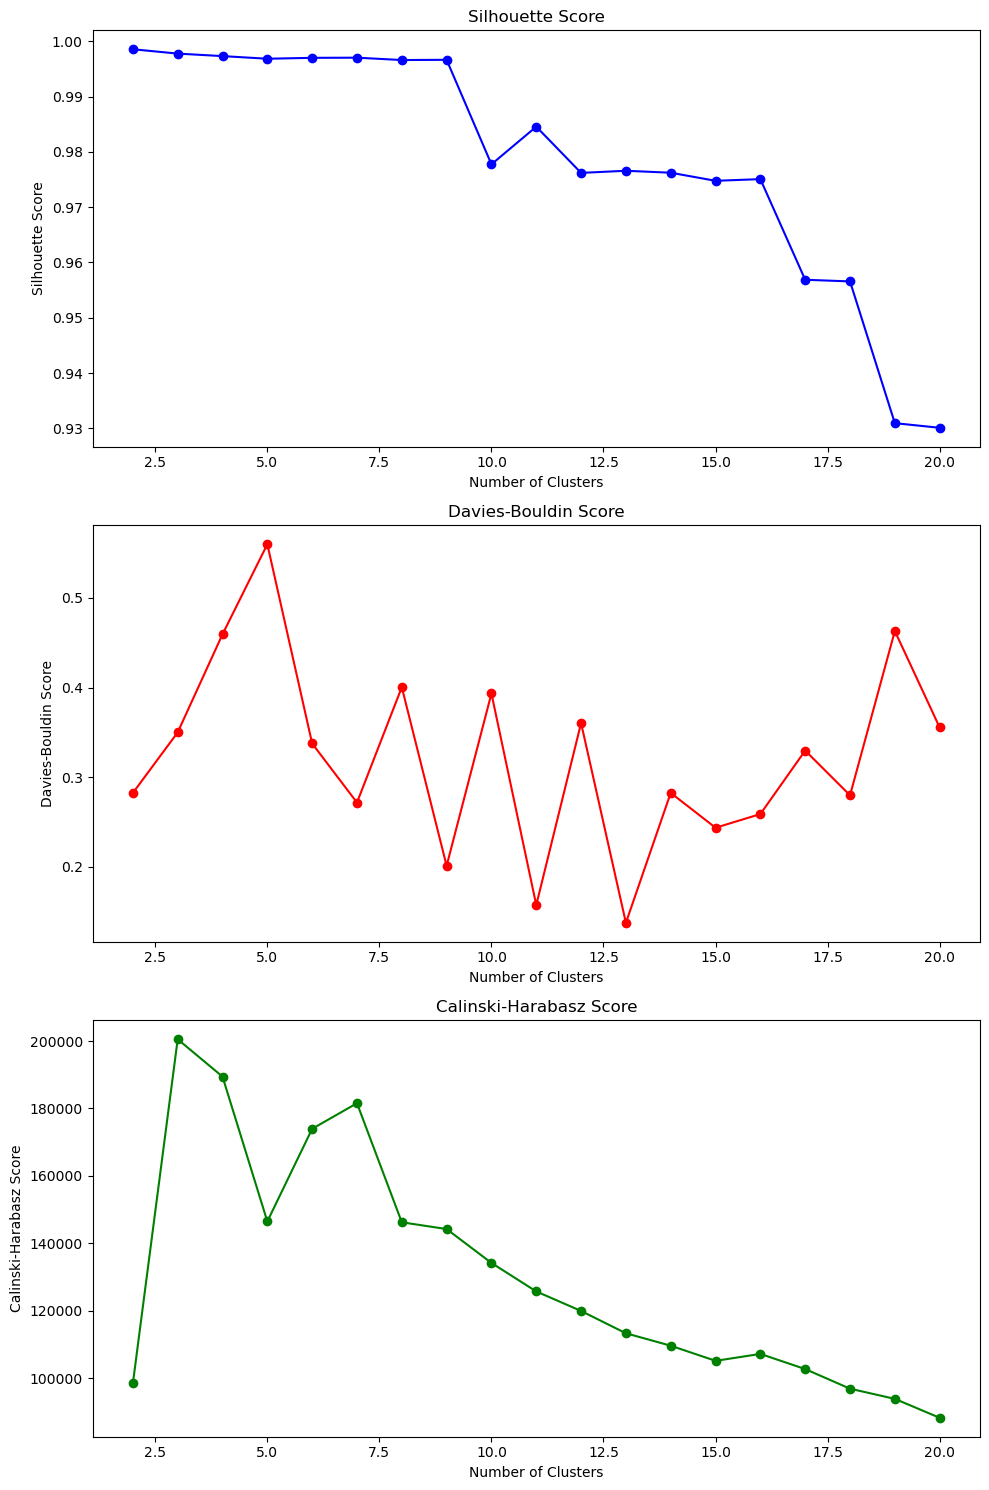

In [5]:
import matplotlib.pyplot as plt
# Plotting the metrics
fig, axs = plt.subplots(3, 1, figsize=(10, 15))

# Silhouette Score
axs[0].plot(range(2, 21), silhouette_scores, marker='o', linestyle='-', color='blue')
axs[0].set_title('Silhouette Score')
axs[0].set_xlabel('Number of Clusters')
axs[0].set_ylabel('Silhouette Score')

# Davies-Bouldin Score
axs[1].plot(range(2, 21), davies_bouldin_scores, marker='o', linestyle='-', color='red')
axs[1].set_title('Davies-Bouldin Score')
axs[1].set_xlabel('Number of Clusters')
axs[1].set_ylabel('Davies-Bouldin Score')
plt.tight_layout()
plt.savefig("Davies-Bouldin Score_News_count-Kmeans.png")
# Calinski-Harabasz Score
axs[2].plot(range(2, 21), calinski_harabasz_scores, marker='o', linestyle='-', color='green')
axs[2].set_title('Calinski-Harabasz Score')
axs[2].set_xlabel('Number of Clusters')
axs[2].set_ylabel('Calinski-Harabasz Score')
plt.tight_layout()
plt.savefig("Calinski-Harabasz Score_News_count-Kmeans.png")
plt.tight_layout()
plt.show()

In [8]:
import pandas as pd
data = {'silhouette_scores':silhouette_scores,'davies_bouldin_scores': davies_bouldin_scores,
        'calinski_harabasz_scores': calinski_harabasz_scores}
df=pd.DataFrame(data,index=range(2, 21))
df

,silhouette_scores,davies_bouldin_scores,calinski_harabasz_scores
2,0.998546,0.282495,98424.378550
3,0.997762,0.350075,200523.053915
4,0.997308,0.459516,189445.624033
5,0.996833,0.559947,146481.091534
6,0.996996,0.337688,173961.687501
7,0.997023,0.271771,181546.776152
8,0.996597,0.400435,146227.730544
9,0.996640,0.201241,144221.072261
10,0.977746,0.393456,134172.272369
11,0.984550,0.157414,125717.156168


In [9]:
df.to_csv('COUNT_PSO+Cuckoo_Scores.csv')